In [72]:
import cv2 as cv 
import numpy as np
from pycocotools.coco import COCO
import os
import json
import seaborn as sns
import random
import matplotlib.pyplot as plt
import torch 
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import albumentations as album 
from sklearn.model_selection import train_test_split
from typing import Callable
from albumentations.pytorch import ToTensorV2
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F


In [73]:
DATASET_PATH = "data"
coco = COCO(f"{DATASET_PATH}/annotations.json")
df=pd.read_csv("data/metadata_splits.csv")
train_ids,valid_ids,test_ids = [],[],[]
for index, row in df.iterrows():
    if row['split_open'] == 'train':
        train_ids.append(row['id'])
    elif row['split_open'] == 'valid':
        valid_ids.append(row['id'])
    elif row['split_open'] == 'test':
        test_ids.append(row['id'])
print(len(train_ids), len(valid_ids), len(test_ids))

loading annotations into memory...
Done (t=1.29s)
creating index...
index created!
5303 1118 2308


In [74]:
class TurtlesDataset(Dataset):
    def __init__(self, coco, image_ids,augmentation=None):
        self.coco = coco
        self.image_ids = image_ids
        self.augmentation = augmentation
        self.catIds = coco.getCatIds()
        self.label_priority = {
            'head': 3,  
            'flipper': 2,
            'turtle': 1 
        }

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image = self.coco.loadImgs([image_id])[0]
        image = cv.imread(f"{DATASET_PATH}/{image['file_name']}")
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.int32)
        priority_map = np.zeros_like(mask)  
        
        ann_ids = coco.getAnnIds(imgIds=image_id, catIds=self.catIds, iscrowd=None)
        anns = coco.loadAnns(ann_ids)
        
        for ann in anns:
            category_id = ann['category_id']
            category_name = coco.loadCats([category_id])[0]['name']
            ann_mask = coco.annToMask(ann)
            
            current_priority = self.label_priority.get(category_name, 0)
    
            mask = np.where((ann_mask == 1) & (priority_map == 0), category_id, mask)
            
            mask = np.where((ann_mask == 1) & (current_priority > priority_map), category_id, mask)
            
            priority_map = np.where(ann_mask == 1, np.maximum(priority_map, current_priority), priority_map)
        image = cv.resize(image, (512, 512))
        mask = cv.resize(mask, (512, 512), interpolation=cv.INTER_NEAREST)
        
        image = image.astype(np.float32)
        mask = mask.astype(np.float32)
        if self.augmentation:
            transformed = self.augmentation(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        transforms = [ToTensorV2()]     
        composed = album.Compose(transforms)
        transformed = composed(image=image, mask=mask)
        image, mask=transformed['image'], transformed['mask']        
        return image, mask

train_dataset = TurtlesDataset(coco, train_ids)
val_dataset = TurtlesDataset(coco, valid_ids)

In [75]:
def calculate_iou(pred, target, num_classes):
    iou_per_class = []
    for cls in range(1,num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        
        if union == 0:
            iou_per_class.append(float('nan')) 
        else:
            iou_per_class.append(intersection / union)
    
    return iou_per_class


In [76]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork

class SwinSegmentation(nn.Module):
    def __init__(self, num_classes):
        super(SwinSegmentation, self).__init__()
        
        # Create a Swin Transformer backbone model using timm
        self.backbone = timm.create_model(
            'swin_small_patch4_window7_224', 
            pretrained=True,
            features_only=True, 
            img_size=512
        )

        # Create an FPN (Feature Pyramid Network) for multi-scale feature fusion
        self.fpn = FeaturePyramidNetwork(
            in_channels_list=[96, 192, 384, 768],  # Input channels from the backbone features
            out_channels=64
        )

        # Convolution layer for classification (outputs num_classes channels)
        self.classifier = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        features = self.backbone(x) 
        # Convert features to (batch, channels, height, width) format
        features = [f.permute(0, 3, 1, 2) for f in features]
        feature_maps = {i: features[i] for i in range(len(features))}
        
        # Fuse multi-scale features using FPN
        fpn_out = self.fpn(feature_maps)
        out = self.classifier(fpn_out[0])  
        # Upsample to the input image size
        out = F.interpolate(out, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=False)
        
        return out


In [77]:
def load_model(weights_path, num_classes=4):
    model = SwinSegmentation(num_classes=num_classes)
    model.load_state_dict(torch.load(weights_path, map_location=torch.device('mps')))
    model.eval()
    return model

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import random

def test_worst(model, test_loader, device, display_num=30):
    model.eval() 
    all_ious = []
    images = [] 
    masks = [] 
    pred_masks = [] 

    with torch.no_grad():
        for i, (image, mask) in enumerate(test_loader):
            image = image.to(device)
            mask = mask.to(device)

        
            pred_mask = model(image)
            pred_mask = torch.argmax(pred_mask, dim=1) 

            pred_mask_np = pred_mask.to("cpu").numpy().squeeze() 
            true_mask_np = mask.to("cpu").numpy().squeeze()      

            iou_per_class = calculate_iou(pred_mask_np, true_mask_np, num_classes=4)
            all_ious.append(iou_per_class)  
            images.append(image.to("cpu"))
            masks.append(mask.to("cpu"))
            pred_masks.append(pred_mask.to("cpu"))

    all_ious = np.array(all_ious)

    mean_iou_per_class = np.nanmean(all_ious, axis=0)
    mean_iou_overall = np.nanmean(mean_iou_per_class)
    print("Mean IoU (Overall):", mean_iou_overall)

    sample_mean_ious = np.nanmean(all_ious, axis=1) 
    worst_indices = np.argsort(sample_mean_ious)[:-display_num] 
    worst_ious = all_ious[worst_indices]  # Get the worst 30 samples IoU values for each category

    print("Worst 30 IoU values (per class for each sample):")
    for idx, iou_per_class in zip(worst_indices, worst_ious):
        print(f"Sample {idx}: IoU per class = {iou_per_class}")

    for idx in worst_indices:
        image_np = images[idx][0].permute(1, 2, 0).numpy().astype(np.int32) 
        true_mask_np = masks[idx].numpy().squeeze()
        pred_mask_np = pred_masks[idx].numpy().squeeze()

        fig, axes = plt.subplots(1, 3, figsize=(5, 5))
        axes[0].imshow(image_np)
        axes[0].set_title('Image')


        axes[1].imshow(true_mask_np, interpolation='none') 
        axes[1].set_title('True Ground')

        axes[2].imshow(pred_mask_np, interpolation='none') 
        axes[2].set_title('Pred Mask')

        plt.show()

    return mean_iou_overall, worst_ious


In [79]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import random

def test_model(model, test_loader, device, display_num=50):
    model.eval() 
    all_ious = []  

    with torch.no_grad():
        for i, (image, mask) in enumerate(test_loader):
            image = image.to(device)
            mask = mask.to(device)

            pred_mask = model(image)
            pred_mask = torch.argmax(pred_mask, dim=1)

    
            pred_mask_np = pred_mask.to("cpu").numpy().squeeze()  
            true_mask_np = mask.to("cpu").numpy().squeeze()       

          
            iou_per_class = calculate_iou(pred_mask_np, true_mask_np, num_classes=4)
            all_ious.append(iou_per_class)

    all_ious = np.array(all_ious)
    mean_iou_per_class = np.nanmean(all_ious, axis=0)
    mean_iou_overall = np.nanmean(mean_iou_per_class)

    print("Class-wise mIoU:", mean_iou_per_class)
    print("Mean IoU (Overall):", mean_iou_overall)

    size=len(test_dataset)
    random_numbers = random.sample(range(size), min(display_num,size))
    for i in random_numbers:
        image, mask = test_dataset[i]
        image = image.unsqueeze(0).to(device) 
        mask = mask.unsqueeze(0).to(device)    

        with torch.no_grad():
            pred_mask = model(image)
            pred_mask = torch.argmax(pred_mask, dim=1)

            pred_mask_np = pred_mask.to("cpu").numpy().squeeze()
            mask_np = mask.to("cpu").numpy().squeeze()
            image_np = image[0].permute(1, 2, 0).to("cpu").numpy().astype(np.int32)

           
            fig, axes = plt.subplots(1, 3, figsize=(5, 5))
            axes[0].imshow(image_np)
            axes[0].set_title('Image')
            

            axes[1].imshow(mask_np, interpolation='none') 
            axes[1].set_title('True Ground')

            axes[2].imshow(pred_mask_np, interpolation='none') 
            axes[2].set_title('Pred Mask')

            plt.show()

    return mean_iou_overall


In [80]:
def visualize(figsize=(16,5), **images):
    n = len(images)
    plt.figure(figsize=figsize)
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()


Class-wise mIoU: [0.93063744 0.84974962 0.82729271]
Mean IoU (Overall): 0.8692265883524332


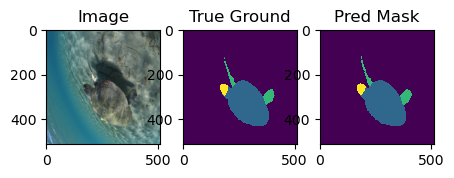

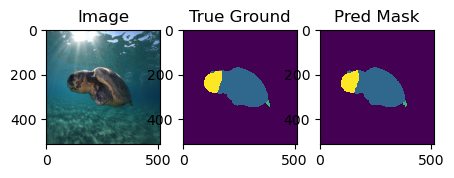

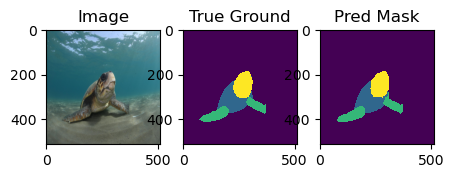

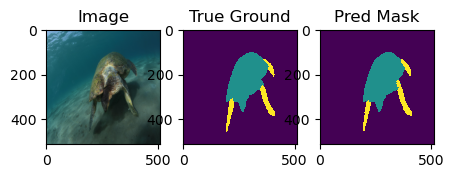

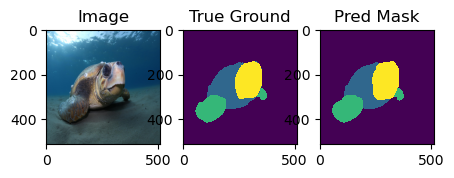

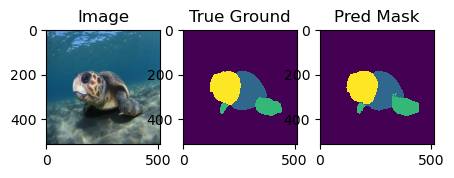

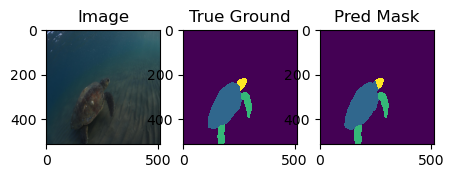

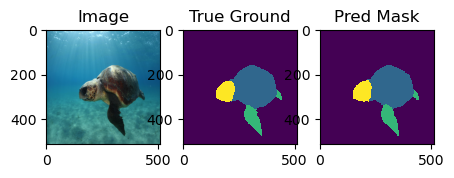

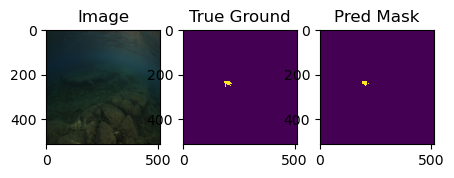

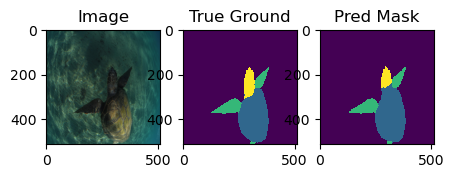

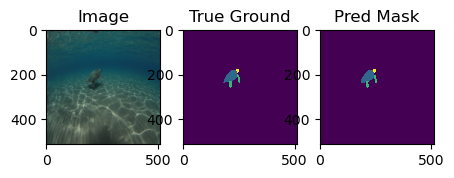

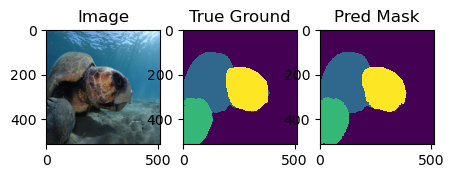

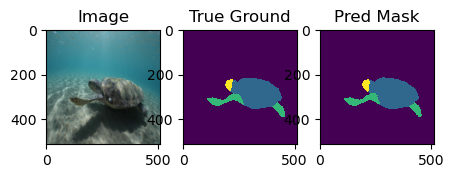

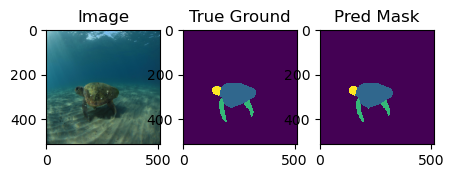

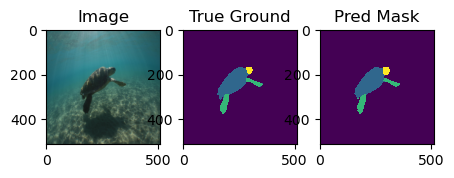

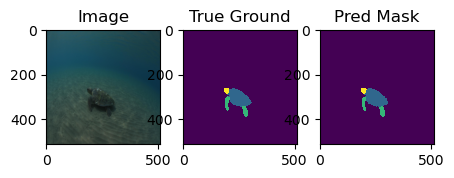

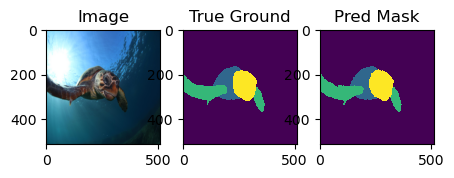

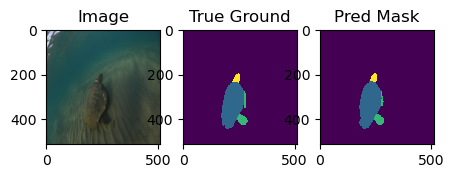

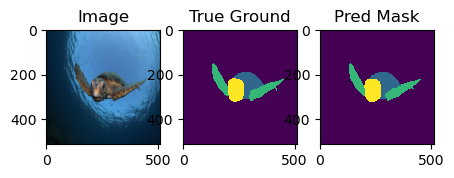

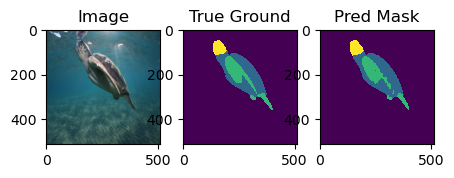

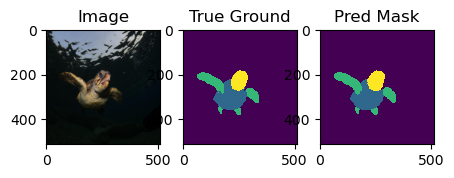

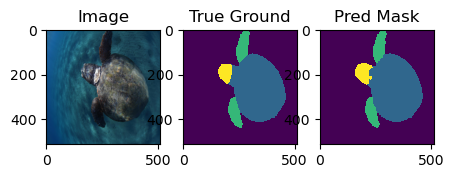

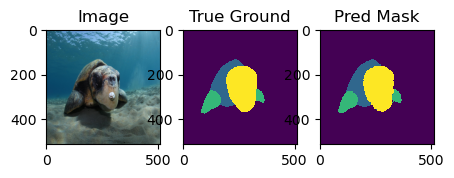

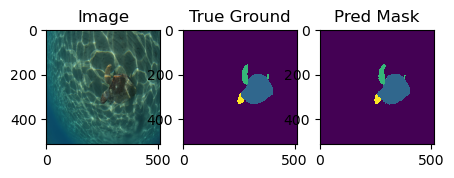

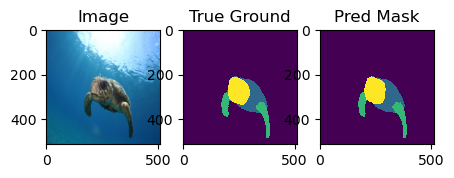

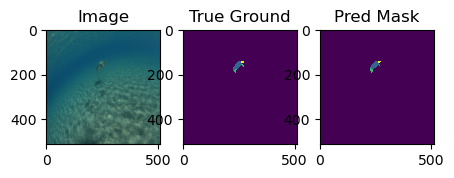

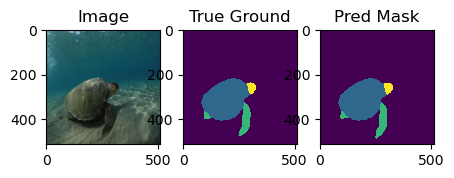

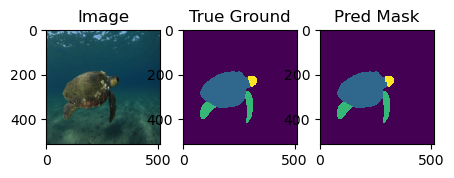

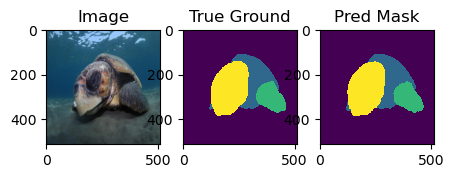

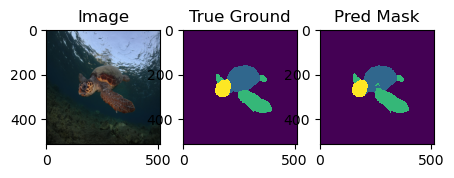

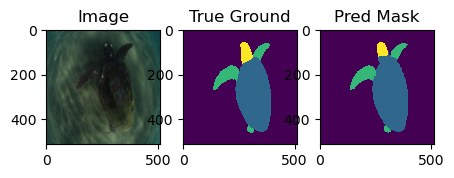

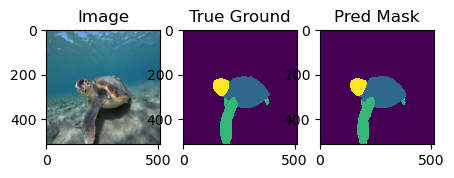

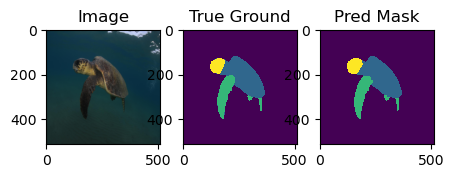

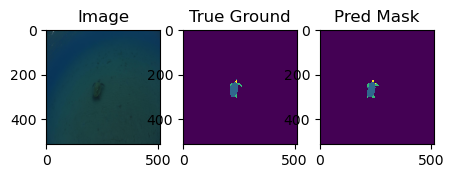

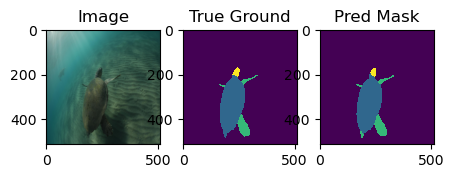

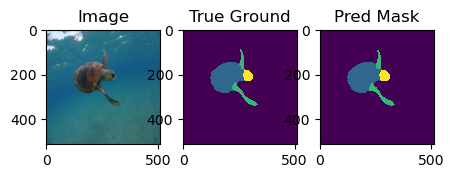

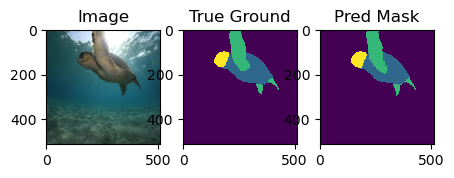

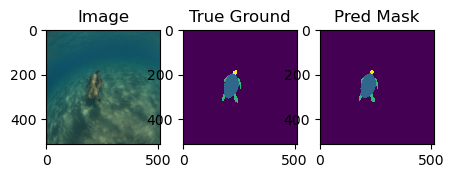

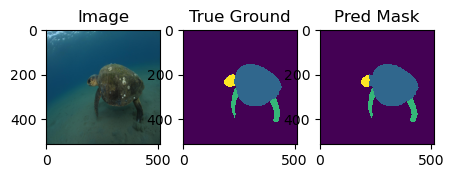

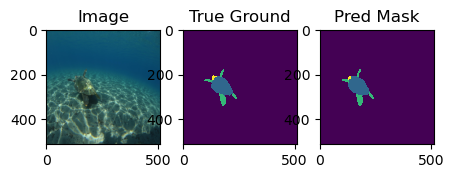

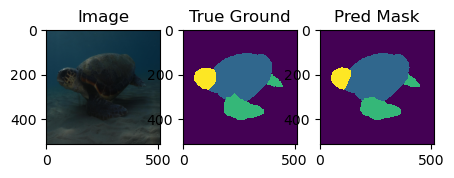

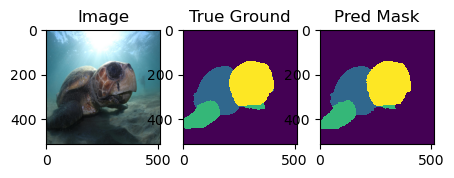

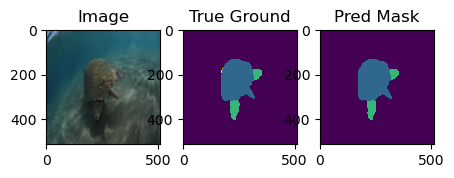

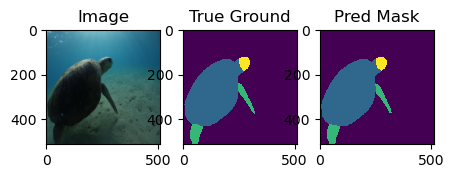

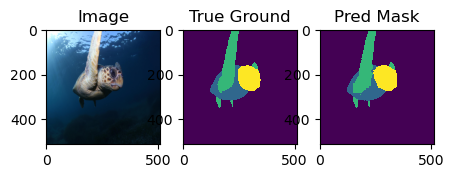

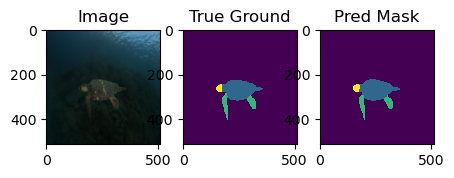

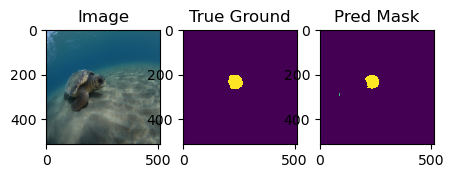

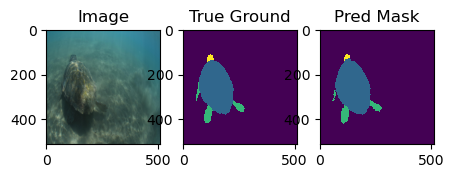

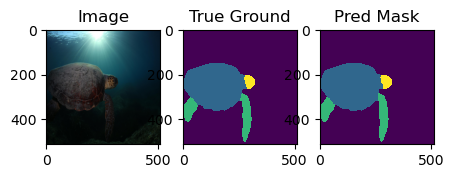

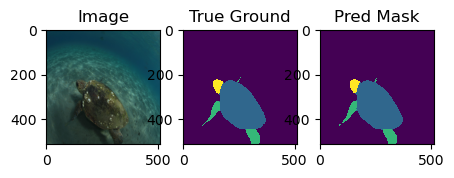

In [81]:
import os
weights_path = './models/best_model.pth'
device='mps'
model = load_model(weights_path, num_classes=4)
model.to(device)  
test_dataset = TurtlesDataset(coco, test_ids)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
lt=test_model(model, test_loader, device)
#print(lt)